# Part 3 - Physics-Informed Neural Networks - Burgers equation

In [3]:
import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [4]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out


In [6]:


# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X, u, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Loss: %e, l1: %.5f, l2: %.5f' % 
                (
                    loss.item(), 
                    self.lambda_1.item(), 
                    torch.exp(self.lambda_2.detach()).item()
                )
            )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item(), 
                        torch.exp(self.lambda_2).item()
                    )
                )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f



In [27]:
from google.colab import files
data = files.upload()

Saving burgers_shock.mat to burgers_shock (2).mat


In [29]:
from scipy.io import loadmat
nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

In [30]:
%%time

noise = 0.0            

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(0)

Loss: 2.392381e-02, l1: 0.17724, l2: 0.00240
Loss: 1.453897e-02, l1: 0.40030, l2: 0.00252
Loss: 9.707768e-03, l1: 0.56804, l2: 0.00298
Loss: 6.311247e-03, l1: 0.74136, l2: 0.00355
Loss: 3.705810e-03, l1: 0.81956, l2: 0.00466
Loss: 2.322793e-03, l1: 0.90033, l2: 0.00528
Loss: 1.400230e-03, l1: 0.93221, l2: 0.00532
Loss: 9.852196e-04, l1: 0.95719, l2: 0.00503
Loss: 6.683046e-04, l1: 0.96370, l2: 0.00458
Loss: 4.389622e-04, l1: 0.97251, l2: 0.00429
Loss: 2.922791e-04, l1: 0.97647, l2: 0.00403
Loss: 2.276500e-04, l1: 0.98769, l2: 0.00382
Loss: 1.663801e-04, l1: 0.98729, l2: 0.00359
Loss: 1.277895e-04, l1: 0.99724, l2: 0.00344
Loss: 9.821400e-05, l1: 0.99503, l2: 0.00336
Loss: 8.435279e-05, l1: 0.99124, l2: 0.00334
Loss: 7.334395e-05, l1: 0.99540, l2: 0.00335
Loss: 6.390874e-05, l1: 0.99588, l2: 0.00335
Loss: 5.697792e-05, l1: 0.99648, l2: 0.00332
Loss: 4.983559e-05, l1: 0.99174, l2: 0.00327
Loss: 4.210375e-05, l1: 0.99561, l2: 0.00323
Loss: 3.675736e-05, l1: 0.99603, l2: 0.00320
Loss: 3.23

In [31]:
# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

Error u: 2.072676e-03
Error l1: 0.03795%
Error l2: 0.35735%


Training on Noisy Data

In [32]:


noise = 0.01    

# create training set
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(10000)            



It: 0, Loss: 4.047e-01, Lambda_1: 0.001, Lambda_2: 0.002478
It: 100, Loss: 8.650e-02, Lambda_1: 0.099, Lambda_2: 0.002154
It: 200, Loss: 3.220e-02, Lambda_1: 0.080, Lambda_2: 0.002126
It: 300, Loss: 2.743e-02, Lambda_1: 0.103, Lambda_2: 0.002135
It: 400, Loss: 2.364e-02, Lambda_1: 0.144, Lambda_2: 0.002105
It: 500, Loss: 2.119e-02, Lambda_1: 0.193, Lambda_2: 0.002149
It: 600, Loss: 1.896e-02, Lambda_1: 0.246, Lambda_2: 0.002225
It: 700, Loss: 1.653e-02, Lambda_1: 0.310, Lambda_2: 0.002344
It: 800, Loss: 1.468e-02, Lambda_1: 0.365, Lambda_2: 0.002518
It: 900, Loss: 1.209e-02, Lambda_1: 0.416, Lambda_2: 0.002694
It: 1000, Loss: 1.013e-02, Lambda_1: 0.466, Lambda_2: 0.002799
It: 1100, Loss: 8.527e-02, Lambda_1: 0.504, Lambda_2: 0.002865
It: 1200, Loss: 9.130e-03, Lambda_1: 0.482, Lambda_2: 0.002917
It: 1300, Loss: 8.253e-03, Lambda_1: 0.515, Lambda_2: 0.002962
It: 1400, Loss: 7.571e-03, Lambda_1: 0.544, Lambda_2: 0.003012
It: 1500, Loss: 7.006e-03, Lambda_1: 0.570, Lambda_2: 0.003068
It: 

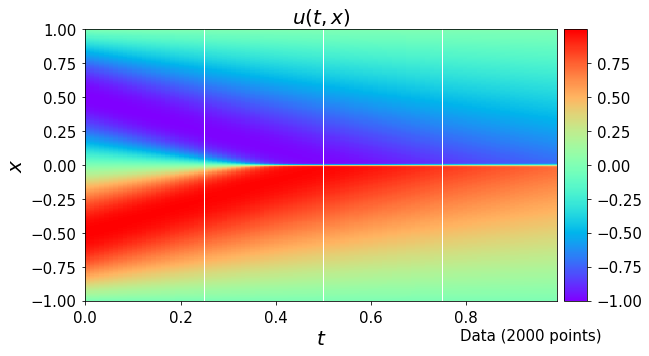

In [33]:


""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()



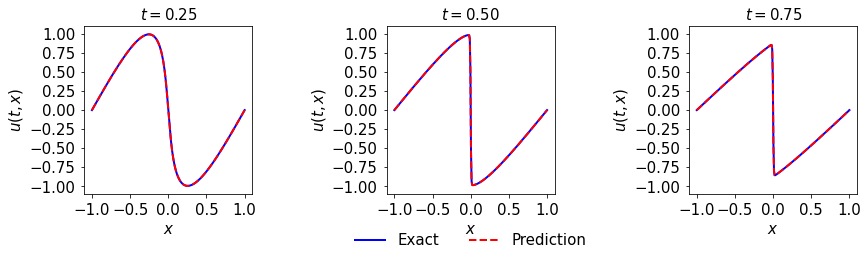

In [34]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()


In [35]:


# evaluations
u_pred, f_pred = model.predict(X_star)

lambda_1_value_noisy = model.lambda_1.detach().cpu().numpy()
lambda_2_value_noisy = model.lambda_2.detach().cpu().numpy()
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0) * 100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1_noisy))                             
print('Error l2: %.5f%%' % (error_lambda_2_noisy))    



Error u: 2.072676e-03
Error l1: 0.15935%
Error l2: 0.34091%


In [43]:
print(lambda_1_value, lambda_2_value)
print(lambda_1_value_noisy, lambda_2_value_noisy)

[0.9996205] [0.00317172]
[0.99840647] [0.00317225]
